# Week 14 Problem 3

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select *Kernel*, and restart the kernel and run all cells (*Restart & Run all*).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select *File* → *Save and CheckPoint*)

5. When you are ready to submit your assignment, go to *Dashboard* → *Assignments* and click the *Submit* button. Your work is not submitted until you click *Submit*.

6. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

7. **If your code does not pass the unit tests, it will not pass the autograder.**

## Author:  Kelechi Ikegwu
### Primary Reviewer: John Nguyen

# Due Date: 6 PM, April 30, 2018

In [1]:
import pymc3 as pm
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from nose.tools import assert_equal, assert_true, assert_false
import numpy.testing as npt 
%matplotlib inline


### Problem 3.1
Complete the function *data_proc* by:
- reading in data from the *file_path* passed in. The data contains the features: *a, b, c,* and the target variable *y*.
- If any row has a *NaN* discard that row.
- Scale the features using [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 
- Perform [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on features a, b, and c and keep 1 component.
- Lastly put your transformed feature and target variable inside of dataframe and return it. Label your transformed feature column as "x" and the column containing your target variable as "y". 
- Set the random_state argument to be zero where applicable.

*HINT*: To make this problem as simple as possible, work with the Pandas library from start to finish.


In [85]:
def data_proc(file_path):
    '''
    Parameters
    ----------
    file_path: contains path to dataset.
    
    Returns
    -------
    pandas dataframe containing feature from transformation methods and the target variable.
    '''
    # YOUR CODE HERE
    data = pd.read_csv(file_path)
    data = data.dropna()
    scaler = StandardScaler()
    sdata = scaler.fit_transform(data)
    sdata = pd.DataFrame(data=sdata,columns=data.columns)
    pca = PCA(n_components=1,random_state=0)
    ndata = sdata[['a','b','c']]
    x = pca.fit_transform(ndata)
    final = pd.DataFrame(data=data.y,columns=['y'])
    final['x']=x
    return final

In [86]:
data = data_proc("/home/data_scientist/data/misc/sim.reg.data")
assert_true(isinstance(data, pd.core.frame.DataFrame), msg=" return a dataframe")
assert_equal(set(data.columns.tolist()), set(['x', 'y']), msg="column names should be x and y")
npt.assert_almost_equal(data.iloc[0:10].values.tolist(), [[2.5126479588783797, 1.533956665095718],
                                                         [1.5829727696817109, 0.5586938336581146],
                                                         [0.840794208649818, -0.1499782117561274],
                                                         [0.3414274033702336, -0.043035754103575186],
                                                         [2.1870799005336403, 1.0553888792108277],
                                                         [2.8112529448802728, 1.5126782938062358],
                                                         [1.642967174697071, -0.1257602123952828],
                                                         [2.870810388330917, 1.4014382467434128],
                                                         [1.9842510428204687, 0.434238338461407],
                                                         [2.0032690074410446, -0.12825186349987105]],
                      decimal=2)

### Problem 3.2

Complete the function *gen_model* by creating general linear model (GLM) using the formula and data passed in.

In [87]:
def gen_model(data, formula):
    '''
    Parameters
    ----------
    data: pandas dataframe from Problem 3.1
    formula: string containing formula to pass into general linear model
    
    Returns
    -------
    GLM model of type pymc3.model.Model
    '''
    # YOUR CODE HERE
    with pm.Model() as model_glm:
        pm.glm.GLM.from_formula(formula, data)
    return model_glm

In [88]:
formula = 'y ~ x + np.power(x, 3)'
model = gen_model(data, formula)

formula2 = 'y ~ x + np.power(x, 2) + np.power(x, 3) + np.power(x,4)'
model2 = gen_model(data, formula2)

assert_true(isinstance(model, pm.model.Model))
for val in ['x', 'y', 'np.power(x, 3)']:
    assert_true(val in model.named_vars)
assert_false('np.power(x, 4)' in model.named_vars)
assert_false('np.power(x, 2)' in model.named_vars)

assert_true(isinstance(model2, pm.model.Model))
for val in ['x', 'y', 'np.power(x, 2)', 'np.power(x, 3)', 'np.power(x, 4)']:
    assert_true(val in model2.named_vars)
assert_false('np.power(x, 5)' in model.named_vars)


### Problem 3.3

Complete the function *gen_trace* by using model *m* to generate *N* trace samples.

In [97]:
def gen_trace(N, m):
    '''
    Parameters
    ----------
    N: integer containing number of samples to generate
    m: pymc3 model to generate traces
    
    Returns
    -------
    trace: pymc3.MultiTrace Instance
    '''
    # YOUR CODE HERE
    with m:
        trace = pm.sample(N)
    return trace

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 2,637.8:   9%|▊         | 17474/200000 [00:03<00:31, 5791.72it/s]
Convergence archived at 18000
Interrupted at 18,000 [9%]: Average Loss = 5,970.8
100%|██████████| 1500/1500 [00:03<00:00, 427.55it/s]


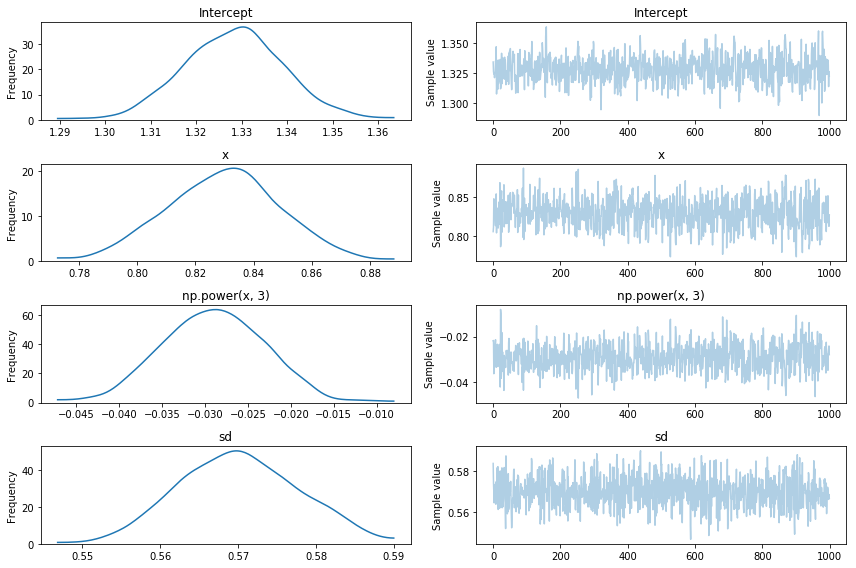

In [98]:
trace = gen_trace(1000, model)
assert_equal(type(trace), pm.backends.base.MultiTrace)
assert_equal(len(trace), 1000)

for val in ['x', 'np.power(x, 3)']:
    assert_true(val in trace.varnames)
assert_false('np.power(x, 2)' in trace.varnames)
assert_false('np.power(x, 4)' in trace.varnames)
pm.traceplot(trace);

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 2,459.6:  14%|█▎        | 27424/200000 [00:05<00:35, 4846.68it/s] 
Convergence archived at 27700
Interrupted at 27,700 [13%]: Average Loss = 10,523
100%|██████████| 1300/1300 [00:05<00:00, 219.51it/s]


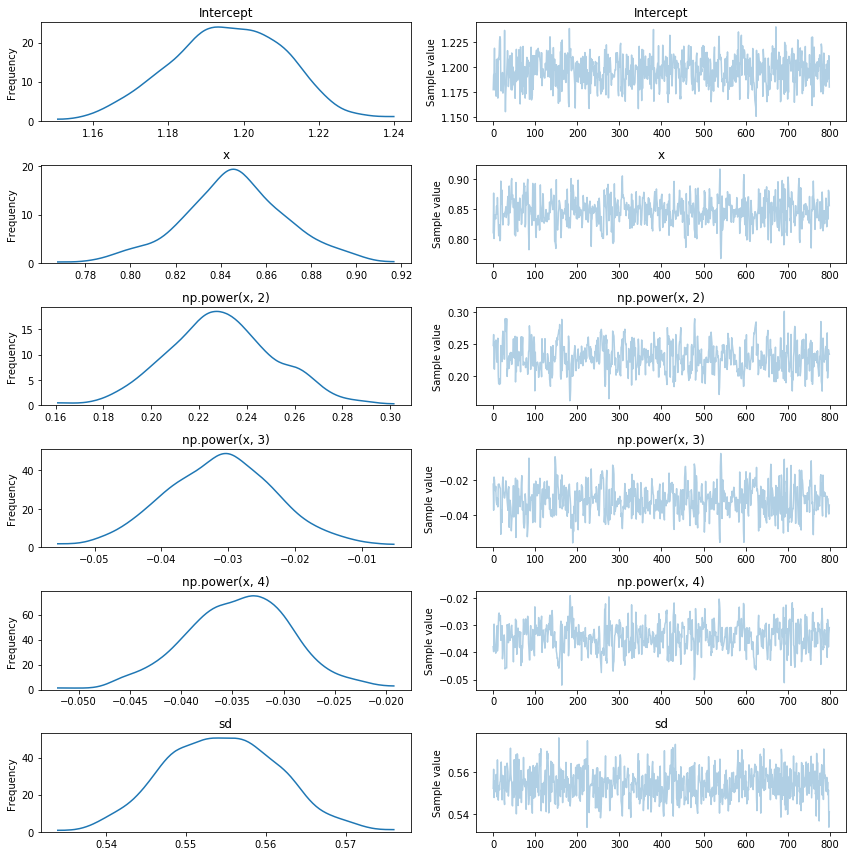

In [99]:
trace = gen_trace(800, model2)
assert_equal(type(trace), pm.backends.base.MultiTrace)
assert_equal(len(trace), 800)

for val in ['x', 'np.power(x, 2)', 'np.power(x, 3)', 'np.power(x, 4)']:
    assert_true(val in trace.varnames)
assert_false('np.power(x, 5)' in trace.varnames)
pm.traceplot(trace);